# EECS 545 Project: VAE Result Interpretation

In [68]:
%cd GeomVAE

#bread and butter
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#exotic clustering algorithm, TDA
from tomaster import tomato
import kmapper
import gudhi
from gudhi.clustering.tomato import Tomato

#machine learning library
import sklearn

#machine learning library for time series
import tslearn
from tslearn.clustering import TimeSeriesKMeans
from tslearn.metrics import dtw

#statistics
import scipy
import scipy.stats as st
from scipy.stats import rankdata, norm
import ot

#misc
%matplotlib inline
plt.style.use('matplotlibrc')

import multiprocessing as mp
import itertools as it
from geomloss import SamplesLoss

[WinError 2] The system cannot find the file specified: 'GeomVAE'
C:\Users\kvnta\OneDrive\Documents\UMich\EECS\EECS 545\Project\GeomVAE


In [2]:
ep100 = np.load("vae-models-100.npy")
ep200 = np.load("vae-models-200.npy")
ep300 = np.load("vae-models-300.npy")

In [3]:
def reader(epoch):
    means = epoch[:,:,0,:].reshape((3*20,7))
    means1 =  epoch[0,:,0,:]
    means2 =  epoch[1,:,0,:]
    means3 =  epoch[2,:,0,:]
    return [means, means1, means2, means3]

def readerCovs(epoch):
    covs = epoch[:,:,1,:].reshape((3*20,7))
    covs1 =  epoch[0,:,1,:]
    covs2 =  epoch[1,:,1,:]
    covs3 =  epoch[2,:,1,:]
    return [np.exp(covs), np.exp(covs1), np.exp(covs2), np.exp(covs3)]

means100,means11_100,means12_100,means13_100 = reader(ep100)
means200,means11_200,means12_200,means13_200 = reader(ep200)
means300,means11_300,means12_300,means13_300 = reader(ep300)

covs100,covs11_100, covs12_100, covs13_100 = readerCovs(ep100)
covs200,covs11_200, covs12_200, covs13_200 = readerCovs(ep200)
covs300,covs11_300, covs12_300, covs13_300 = readerCovs(ep300)

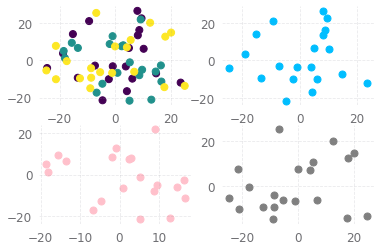

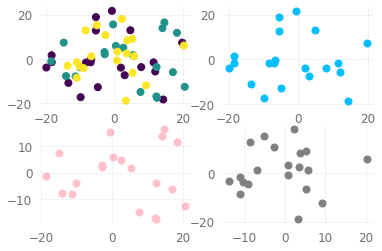

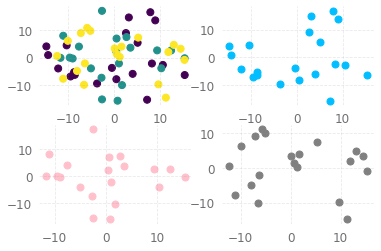

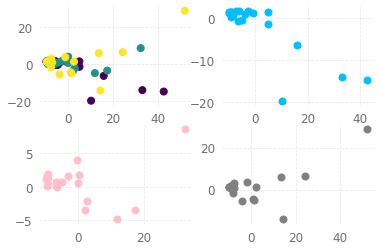

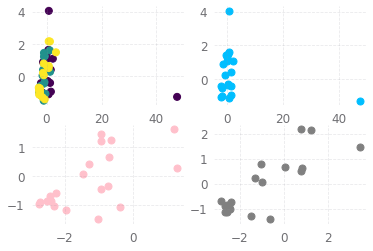

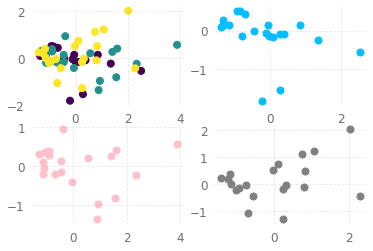

In [122]:
def pcaPlot(means, means1, means2, means3, 
            color = [0 for i in range(20)] + [1 for i in range(20)] + [2 for i in range(20)]):
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)

    pca = sklearn.decomposition.PCA(n_components=2).fit_transform(means)
    
    ax1.scatter(pca[:,0], pca[:, 1], c = color)

    #pca = sklearn.decomposition.PCA(n_components=2).fit_transform(means1)
    ax2.scatter(pca[0:len(means1),0], pca[0:len(means1), 1])

    #window = len(means1):(len(means1) + len(means2))
    #pca = sklearn.decomposition.PCA(n_components=2).fit_transform(means2)
    ax3.scatter(pca[len(means1):(len(means1) + len(means2)),0], 
                pca[len(means1):(len(means1) + len(means2)), 1], c='pink')

    #window = (len(means1) + len(means2)):(len(means2) + len(means3))
    #pca = sklearn.decomposition.PCA(n_components=2).fit_transform(means3)
    ax4.scatter(pca[(len(means1) + len(means2)):,0], 
                pca[(len(means1) + len(means2)):,1], c='gray')
    
pcaPlot(means100,means11_100,means12_100,means13_100)
pcaPlot(means200,means11_200,means12_200,means13_200)
pcaPlot(means300,means11_300,means12_300,means13_300)

pcaPlot(covs100,covs11_100, covs12_100, covs13_100)
pcaPlot(covs200,covs11_200, covs12_200, covs13_200)
pcaPlot(covs300,covs11_300, covs12_300, covs13_300)

In [115]:
means = np.r_[means100, means200, means300]
means11 = np.r_[means11_100, means11_200, means11_300]
means12 = np.r_[means12_100, means12_200, means12_300]
means13 = np.r_[means13_100, means13_200, means13_300]
covs = np.r_[covs100, covs200, covs300]
covs11 = np.r_[covs11_100, covs11_200, covs11_300]
covs12 = np.r_[covs12_100, covs12_200, covs12_300]
covs13 = np.r_[covs13_100, covs13_200, covs13_300]

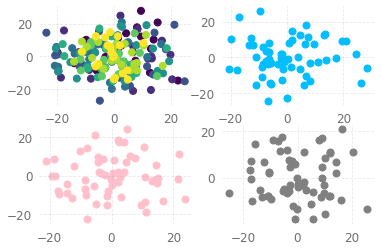

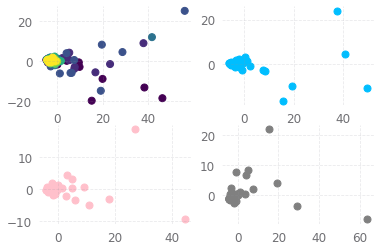

In [116]:
col = [0 for i in range(20)] + [1 for i in range(20)] + [2 for i in range(20)]
col += [3 for i in range(20)] + [4 for i in range(20)] + [5 for i in range(20)]
col += [6 for i in range(20)] + [7 for i in range(20)] + [8 for i in range(20)]
pcaPlot(means, means11, means12, means13, color = col)
pcaPlot(covs, covs11, covs12, covs13, color = col)

In [ ]:
mvnorms100 = [st.multivariate_normal(means, np.diag(covs)) for means,covs in zip(means100, covs100)]
mvnorms200 = [st.multivariate_normal(means, np.diag(covs)) for means,covs in zip(means200, covs200)]
mvnorms300 = [st.multivariate_normal(means, np.diag(covs)) for means,covs in zip(means300, covs300)]

In [78]:
def distSinkMat(mvnorms):
    loss = SamplesLoss("sinkhorn", p=2, backend="tensorized")
    n = len(mvnorms)
    distMat = np.zeros((n,n))
    for i in range(n):
        if j < i:
            print(i)
            for j in range(n):
                distMat[i,j] = loss(torch.from_numpy(mvnorms[i].rvs(1000)), 
                                    torch.from_numpy(mvnorms[j].rvs(1000))).item()
                distMat[j,i] = distMat[i,j]
    return distMat

In [82]:
dist100 = distSinkMat(mvnorms100)
dist200 = distSinkMat(mvnorms200)
dist300 = distSinkMat(mvnorms300)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59


In [83]:
#np.save("dist100", dist100)
#np.save("dist200", dist200)
#np.save("dist300", dist300)

In [88]:
np.fill_diagonal(dist100, 0)
np.fill_diagonal(dist200, 0)
np.fill_diagonal(dist300, 0)
dist100S = np.maximum( dist100, dist100.T )
dist200S = np.maximum( dist200, dist200.T )
dist300S = np.maximum( dist300, dist300.T )

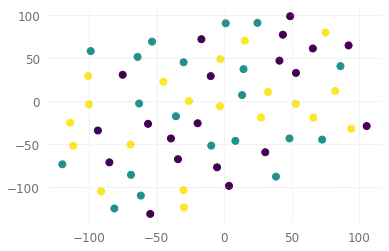

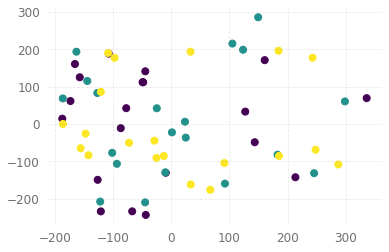

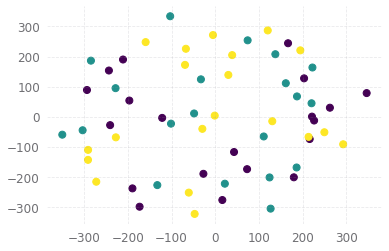

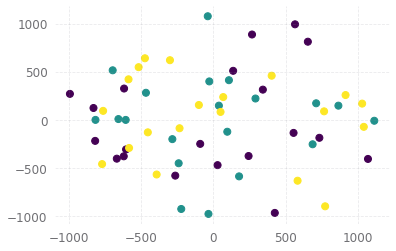

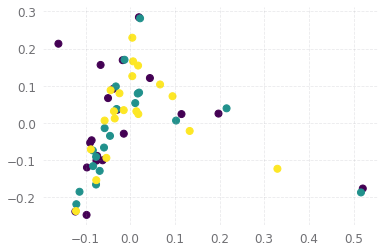

In [134]:
color = [0 for i in range(20)] + [1 for i in range(20)] + [2 for i in range(20)]
d=dist300S
tsne = sklearn.manifold.TSNE(n_components=2, metric="precomputed").fit_transform(d)
fig, ax = plt.subplots()
ax.scatter(tsne[:,0], tsne[:, 1], c = color)

tsne = sklearn.manifold.Isomap(n_components=2, metric="precomputed").fit_transform(d)
fig, ax = plt.subplots()
ax.scatter(tsne[:,0], tsne[:, 1], c = color)

tsne = sklearn.manifold.MDS(n_components=2, dissimilarity="precomputed").fit_transform(d)
fig, ax = plt.subplots()
ax.scatter(tsne[:,0], tsne[:, 1], c = color)

tsne = sklearn.decomposition.PCA(n_components=2).fit_transform(d)
fig, ax = plt.subplots()
ax.scatter(tsne[:,0], tsne[:, 1], c = color)

tsne = sklearn.manifold.LocallyLinearEmbedding(n_components=2).fit_transform(d)
fig, ax = plt.subplots()
ax.scatter(tsne[:,0], tsne[:, 1], c = color)

In [110]:
np.sum(dist100S)

3145265.7043912197

In [5]:
# Jensen-Shannon distance requires same probability space. Are levels 1-1, 1-2 on the same? Probably not.
'''
def jsDist(distribution_p, distribution_q, n_samples=10 ** 5):
    # jensen shannon distance. (Jensen shannon distance is the square root of the divergence)
    # all the logarithms are defined as log2 (because of information entrophy)
    X = distribution_p.rvs(n_samples)
    p_X = distribution_p.pdf(X)
    q_X = distribution_q.pdf(X)
    log_mix_X = np.log2(p_X + q_X)

    Y = distribution_q.rvs(n_samples)
    p_Y = distribution_p.pdf(Y)
    q_Y = distribution_q.pdf(Y)
    log_mix_Y = np.log2(p_Y + q_Y)

    return np.sqrt(np.abs((np.log2(p_X).mean() - (log_mix_X.mean() - np.log2(2))
            + np.log2(q_Y).mean() - (log_mix_Y.mean() - np.log2(2))) / 2))

print("should be different:")
print(jsDist(st.norm(loc=100), st.norm(loc=0)))
print("should be same:")
print(jsDist(st.norm(loc=0), st.norm(loc=0)))
'''

should be different:
1.0
should be same:
2.5809568279517847e-08


In [12]:
'''
def distJSMat(mvnorms):
    n = len(mvnorms)
    distMat = np.zeros((n,n))
    for i in range(n):
        for j in range(n):
            distMat[i,j] = jsDist(mvnorms[i], mvnorms[j])
    return distMat

dist100 = distJSMat(mvnorms100)
dist200 = distJSMat(mvnorms200)
dist300 = distJSMat(mvnorms300)
'''

In [ ]:
'''
def jsDistPar(*args):
        # jensen shannon distance. (Jensen shannon distance is the square root of the divergence)
        # all the logarithms are defined as log2 (because of information entropy)
        i, j, mvnorms = args 
        distribution_p = mvnorms[i]
        distribution_q = mvnorms[j]
        n_samples= 10 ** 5
        X = distribution_p.rvs(n_samples)
        p_X = distribution_p.pdf(X)
        q_X = distribution_q.pdf(X)
        log_mix_X = np.log2(p_X + q_X)

        Y = distribution_q.rvs(n_samples)
        p_Y = distribution_p.pdf(Y)
        q_Y = distribution_q.pdf(Y)
        log_mix_Y = np.log2(p_Y + q_Y)

        return np.sqrt(np.abs((np.log2(p_X).mean() - (log_mix_X.mean() - np.log2(2))
                + np.log2(q_Y).mean() - (log_mix_Y.mean() - np.log2(2))) / 2))

def distJSMat(mvnorms):
    p = mp.Pool(processes=8)
    n = len(mvnorms)
    #input = ((i,j, mvnorms) for i,j in it.combinations_with_replacement(range(n), 2) if i < n)
    results = p.map(jsDistPar, [(i, j, mvnorms) for i in range(n) for j in range(n)])
    p.close()
    p.join()
    return results

dist100 = distJSMat(mvnorms100)
'''

In [66]:
xs = mvnorms100[1].rvs(1000)
xt = mvnorms100[2].rvs(1000)
n=1000

a, b = np.ones((n,)) / n, np.ones((n,)) / n  # uniform distribution on samples

M = ot.dist(xs, xt, metric='euclidean')
#M /= M.max()

In [59]:
a.shape

(1000,)

In [60]:
G0 = ot.emd(a, b, M)

In [67]:
ot.emd2(a, b, M)

42.9063766893413

In [61]:
np.trace(np.dot(np.transpose(G0), M))

0.8619221923168701

In [65]:
np.sum(G0*M)

0.8619221923168703

In [80]:
import torch
from layers import SinkhornDistance

xs = mvnorms100[1].rvs(1000)
xt = mvnorms100[2].rvs(1000)

x = torch.tensor(xs, dtype=torch.float)
y = torch.tensor(xt, dtype=torch.float)

sinkhorn = SinkhornDistance(eps=0.01, max_iter=100, reduction=None)
dist, P, C = sinkhorn(x, y)
print("Sinkhorn distance: {:.3f}".format(dist.item()))


Sinkhorn distance: 1833.132


In [81]:
from geomloss import SamplesLoss

loss = SamplesLoss("sinkhorn", p=2, backend="tensorized")
loss(torch.from_numpy(xs), torch.from_numpy(xt)).item()

922.0179353716303